In [1]:
import re
import pandas as pd
import os
import numpy as np
import sys
import json
%matplotlib inline

rootdir = '/Users/lguillain/Documents/EPFL2018/Semester-Project/papers-import'

## loading content of txt files..

In [2]:
contents = []
i = 0
source = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if 'txt' in file:
            i += 1
            path = os.path.join(subdir, file)
            with open(path) as file:
                try:
                    text = file.read()
                    contents.append(text)
                    source.append(subdir[len(rootdir):])
                except:
                    name, message, content = sys.exc_info()
                    print(message)

## extracting the reference function from the text

In [3]:
def ref_extraction(text, extract=False):
    """extracts refrerence section: works well on well formated documents"""
    mention = text.lower().rfind("references")
    
    #get reference section, account for different spelling
    acknowledgements = max(text.lower().find("acknowledgements"), text.lower().find('acknowledgments'))
    ref = text[mention+len("references"):acknowledgements]
    
    #split up different references
    references = ref.split('.\n')
    ref = [r for r in references if len(r) > 10]
    
    if extract:
        #use regex to parse, splits if "." format ignores S. and . within paranteses
        #Stable enough to get authors & year (first line)
        ref = [re.sub('\.(?![^\(]*\))(?<!\s[A-Z]\.)', '_#_', r).split('_#_') for r in ref]
    return ref

In [4]:
len(source)

428

In [5]:
#counts = []
references = []
for i, content in enumerate(contents):
    references.append((ref_extraction(content)))

# looking into regex to check if valid:

One way we can know a line was split early is if it starts with lowercase letter or with a number

In [6]:
re.match(r'^[0-9\–]*(?![A-Z])', '3(3),535-554.')

<re.Match object; span=(0, 1), match='3'>

In [7]:
re.match('^[A-Z][^.]*[?.!]$', 'Abjdbsf . ')

In [8]:
re.match('^[a-z]', 'http://www.joanganzcooneycenter.org/publication/the-new-coviewing-designing-for-learning-throughjoint-media-engagement/')

<re.Match object; span=(0, 1), match='h'>

In [9]:
bad_strings = ["ICLS 2016 Proceedings", 'CSCL 2017 Proceedings']

The below may need to be run multiple times

In [10]:
#moving sentences starting with lowercase letter or number strings "one up"
def moving_down(issues):
    issues = [i for i in issues if len(i) > 0 and not re.match(r'(CSCL|ICLS) \d{4} Proceedings', i)]
    patchwork = ['']*len(issues)
    for i, sentence in enumerate(issues):
        if i != 0 and (re.match('^[a-z]', sentence) or re.match(r'^[0-9\–]*(?![A-Z])', sentence)): 
            j = 1
            while len(patchwork[i-j]) == 0:
                j += 1
            patchwork[i-j] += ' ' + sentence
        else:
            patchwork[i] = sentence
    return patchwork

In [11]:
re.match(r'([\s\S]*\ [A-Z]\.\ *$)', 'dbsjbfdhj dhfdjhf A.  dhfghf, £ A.')

<re.Match object; span=(0, 34), match='dbsjbfdhj dhfdjhf A.  dhfghf, £ A.'>

In [12]:
#issues = [i for i in issues if len(i) > 0]
#fix code here
def moving_up(issues):
    matches = True
    i = 0
    while matches:
        match = False
        p = move_up_once(issues)
        issues = p
        matches = match
        i += 1
        if i > 20:
            print(issues)
            return 1
    return p

In [13]:
def move_up_once(issues):
    issues = [i for i in issues if len(i) > 0]
    p = ['']*len(issues)
    for i, sentence in enumerate(issues):
        
        #We move a sentence up if its ending indicates incompletness -> small letter, initial
        # or if it is an incomplete citation -> must contain a year
        
        if re.match('[\s\S]*[a-z\,\:]\ ?$', sentence) or re.match(r'([\s\S]*\ [A-Z]\.\ *$)', sentence)\
        or not re.match(r'.*\(\d{4}\)', sentence):
            #print(sentence)
            if i+1 < len(issues):
                match = True
                p[i] =  sentence +' '+issues[i+1]
            #print(sentence[-10:])
        else:
            p[i] = sentence
    return p

In [14]:
r = []
for i, ref in enumerate(references):
    tmp = moving_down(ref)
    tmp = [i.replace('\n', '') for i in tmp if len(i) > 0]
    r.append([(t, source[i]) for t in tmp])

In [15]:
references_df = pd.DataFrame([f for flat in r for f in flat], columns=['ref', 'file'])

In [16]:
references_df.head()

,ref,file
0,"Abrahamson, D. (2012). Discovery reconceived: ...",/import2016full/61
1,"Abrahamson, D. (2015). The monster in the mach...",/import2016full/61
2,"Abrahamson, D., Lee, R. G., Negrete, A. G., & ...",/import2016full/61
3,"Abrahamson, D., & Sánchez-García, R. (in press...",/import2016full/61
4,"Abrahamson, D., Shayan, S., Bakker, A., & Van ...",/import2016full/61


In [17]:
references_df['length'] = references_df.ref.map(lambda x: len(x))

In [18]:
references_df.length.describe()

count     8647.000000
mean       199.030531
std        865.821299
min         11.000000
25%        110.000000
50%        165.000000
75%        211.000000
max      74522.000000
Name: length, dtype: float64

# Approach to get names from references:

In [19]:
nicer_refs = references_df.ref.tolist()

For APA style it is easy to extract the year and author of the cited reference
- we could look at from when the reference cited is, who is in it

Need to look at efficient way to check name validity:
think spanish, irish names

In [20]:
def get_authors(sentence, debug = False):
    if re.match(r'[\w\ \. \,\&\(\)\-\']*\(\d{4}\)', sentence):
        s = re.findall(r'[\w\ \. \,\&\(\)\-\']*\(\d{4}\)', sentence)[0]
        if len(s) > 9:
            #print(s)
            return (s)
    elif debug:
        return '#'+sentence
    
    return np.nan

In [21]:
references_df.apply(lambda x: get_authors(x['ref'], debug=True), axis=1)[3]

'#Abrahamson, D., & Sánchez-García, R. (in press). Learning is moving in new ways: The ecological dynamics ofmathematics education. Journal of the Learning Sciences. doi:10.1080/10508406.2016.1143370'

In [22]:
references_df.apply(lambda x: get_authors(x['ref'], debug=True), axis=1)[4]

'#Abrahamson, D., Shayan, S., Bakker, A., & Van der Schaaf, M. F. (in press). Eye-tracking Piaget: Capturing theemergence of attentional anchors in the coordination of proportional motor action. Human Development'

In [23]:
references_df.apply(lambda x: get_authors(x['ref'], debug=True), axis=1)[8634]

'#Ito, M., Gutiérrez, K., Livingstone, S., Penuel, B., Rhodes, J., Salen, K., … Watkins, S. C. (2013). Connectedlearning: An agenda for research and design. Digital Media and Learning Research Hub'

In [24]:
references_df['ref_parsed'] = references_df.apply(lambda x: get_authors(x['ref']), axis=1)

In [25]:
references_df.ref_parsed.isna().sum()/references_df.ref_parsed.shape[0]

0.1827223314444316

In [26]:
references_df.ref_parsed.shape[0]

8647

In [27]:
ref_counts = references_df.groupby('file').ref_parsed.count()
ref_counts.name = 'counts'
ref_counts.head()

file
/import2015full/105    31
/import2015full/122    28
/import2015full/126    43
/import2015full/136     6
/import2015full/146    19
Name: counts, dtype: int64

In [28]:
ref_counts.describe()

count    419.000000
mean      16.866348
std       10.003650
min        0.000000
25%       10.000000
50%       15.000000
75%       21.500000
max       75.000000
Name: counts, dtype: float64

In [29]:
references_df.head()

,ref,file,length,ref_parsed
0,"Abrahamson, D. (2012). Discovery reconceived: ...",/import2016full/61,113,"Abrahamson, D. (2012)"
1,"Abrahamson, D. (2015). The monster in the mach...",/import2016full/61,190,"Abrahamson, D. (2015)"
2,"Abrahamson, D., Lee, R. G., Negrete, A. G., & ...",/import2016full/61,192,"Abrahamson, D., Lee, R. G., Negrete, A. G., & ..."
3,"Abrahamson, D., & Sánchez-García, R. (in press...",/import2016full/61,197,NaN
4,"Abrahamson, D., Shayan, S., Bakker, A., & Van ...",/import2016full/61,210,NaN


In [30]:
df = references_df.join(ref_counts, on='file')
df.head()

,ref,file,length,ref_parsed,counts
0,"Abrahamson, D. (2012). Discovery reconceived: ...",/import2016full/61,113,"Abrahamson, D. (2012)",43
1,"Abrahamson, D. (2015). The monster in the mach...",/import2016full/61,190,"Abrahamson, D. (2015)",43
2,"Abrahamson, D., Lee, R. G., Negrete, A. G., & ...",/import2016full/61,192,"Abrahamson, D., Lee, R. G., Negrete, A. G., & ...",43
3,"Abrahamson, D., & Sánchez-García, R. (in press...",/import2016full/61,197,NaN,43
4,"Abrahamson, D., Shayan, S., Bakker, A., & Van ...",/import2016full/61,210,NaN,43


We see that only papers that are invalid have no citation

In [31]:
df[df.counts < 1].ref.tolist()

['nalysis ...................................................................................................................................................... 66coaching.............................................................................................................................................................. 506co-design........................................................................................................................................................... 1128coding scheme .................................................................................................................................................. 1195cognition ................................................................................................................................................... 811, 1241cognitive and non-cognitive factors.................................................................................................................. 1153cognitive de

In [32]:
df[df.counts == 2]

,ref,file,length,ref_parsed,counts
2020,marked with an asterisk indicate studies incl...,/import2015full/192,1105,NaN,2
2021,Design and reflection help students develop sc...,/import2015full/192,658,NaN,2
2022,Educational Technology Research and Developmen...,/import2015full/192,985,NaN,2
2023,"Thousand Oaks, CA: Sage Publications * Roschel...",/import2015full/192,137,NaN,2
2024,Scaffolding group explanation and feedback wit...,/import2015full/192,339,NaN,2
2025,"Strauss, A. L. (1987). Qualitative analysis fo...",/import2015full/192,101,"Strauss, A. L. (1987)",2
2026,"Strauss, A. L., & Corbin, J. (1998). Basics of...",/import2015full/192,496,"Strauss, A. L., & Corbin, J. (1998)",2
2027,Educational Technology Research and Developmen...,/import2015full/192,405,NaN,2
2028,"Hmelo-Silver (Eds.), International Handbook of...",/import2015full/192,647,NaN,2
4707,marked with an asterisk indicate studies incl...,/import2015short/192,1105,NaN,2


In [33]:
df[df.counts == 5]

,ref,file,length,ref_parsed,counts
767,"Bielaczyc, K. (2006). Designing social infrast...",/import2016full/17,166,"Bielaczyc, K. (2006)",5
768,"Brown, A. L. (1992). Design experiments: Theor...",/import2016full/17,161,"Brown, A. L. (1992)",5
769,"Kolodner, J. (2004). The learning sciences: Pa...",/import2016full/17,106,"Kolodner, J. (2004)",5
770,"Luhmann, N. (1990). Essays on self-reference. ...",/import2016full/17,81,"Luhmann, N. (1990)",5
771,"Nathan, M. J., Rummel, N., & Hay, K. E. (forth...",/import2016full/17,281,NaN,5
772,"Sawyer, K. (2014). Introduction: The new scien...",/import2016full/17,161,"Sawyer, K. (2014)",5
1260,"Fitzgerald, J., (1987). Research on revision i...",/import2016full/52,103,"Fitzgerald, J., (1987)",5
1261,"Gerard, L., Ryoo, K., McElhaney, K., Liu, L., ...",/import2016full/52,1166,"Gerard, L., Ryoo, K., McElhaney, K., Liu, L., ...",5
1262,"Mullis, I.V. S. & Jenkins, L.B. (1988). The sc...",/import2016full/52,201,"Mullis, I.V. S. & Jenkins, L.B. (1988)",5
1263,"Princeton, NJ: Educational Testing Service",/import2016full/52,42,NaN,5


In [34]:
ref_counts[ref_counts == 2]

file
/import2015full/192     2
/import2015short/192    2
Name: counts, dtype: int64

In [35]:
references_df[references_df.file == '/import2016short/136']

,ref,file,length,ref_parsed
4100,with regard to collaborationaffect the satisf...,/import2016short/136,298,NaN
4101,H4: The individual learning preference for col...,/import2016short/136,804,NaN
4102,Before participation in the course students we...,/import2016short/136,825,NaN
4103,In a time period from week 6 to 10 students co...,/import2016short/136,653,NaN
4104,Students participated in several online questi...,/import2016short/136,721,NaN
4105,We assessed intrinsic motivation of the studen...,/import2016short/136,335,We assessed intrinsic motivation of the studen...
4106,"Further, we employed Johnson and Norem-Hebeise...",/import2016short/136,243,NaN


In [36]:
references_df.iloc[4105].ref_parsed

'We assessed intrinsic motivation of the students at the beginning of the course using 5 items from theacademic self-regulation questionnaire (SRQ-A) by Müller, Hanfstingl, and Andreitz (2007)'

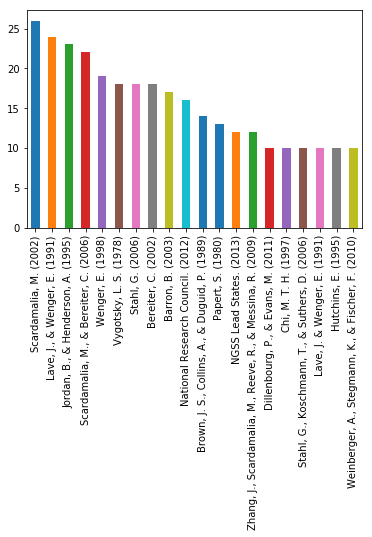

In [40]:
references_df.ref_parsed.value_counts().head(20).plot(kind='bar')

## Todo: 
- extract year, individual author
- right now this might give a decent paper identifier

## trying to parse acm authors

In [ ]:
ACM_authors = []
for i, ref in enumerate(references):
    for sentence in ref:
        s =  re.findall(r'[a-zA-Z\ \. \,]*\d{4}\. ', sentence)
        if re.match(r'[a-zA-Z\ \. \,]*\d{4}\. ', sentence) and not 'http' in s[0].lower() and len(s[0]) > 10:
            #print(sentence)
            print(s[0])
            #apa_authors.append((re.findall(r'.*\(\d{4}\)', sentence)[0], source[i]))

In [ ]:
re.match(r'(.*\d{4}\. )', "https://www.nsf.gov/funding/pgm_summ.jsp?pims_id=5467. Retrieved August 19, 2016.")

In [ ]:
m = re.match(r'.*\d{4}\. ', 'https://www.nsf.gov/funding/pgm_summ.jsp?pims_id=5467. Retrieved August 19, 2016.')

In [ ]:
re.findall(r'[a-zA-Z\ \. \,]*\d{4}\. ', 'McKenzie, W., and Murphy, D. 2000. “I hope this goes somewhere”: Evaluation of an on')